In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


# Modelo 1: predição de Tipo de Meningite

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from joblib import dump

In [ ]:
# Carregar o dataset
file_path = "/content/drive/MyDrive/ PROJETOS/ML Predição minigites /dados_bacterianas.csv"
data = pd.read_csv(file_path)

In [ ]:
# Carregar o dataset
data = pd.read_csv("df_treino_isbac.csv")
data.head()

,NU_NOTIFIC,DT_NOTIFIC,etiologia,grupo_etiologico,idade,faixa_etaria1,faixa_etaria2,faixa_etaria3,sexo,CS_RACA,...,LAB_NEUTRO,LAB_GLICO,LAB_LEUCO,LAB_PROT,LAB_MONO,LAB_LINFO,LAB_CLOR,internacao,evolucao,is_bac
0,4503282,2019-03-28,Asseptica,Asseptica,4.0,0 a 4 anos,2 a 4 anos,2 a 4 anos,Masculino,1.0,...,55.0,64.0,66.0,19.0,NaN,45.0,109.0,Sim,Alta,nonbacterial
1,4626442,2019-05-02,Asseptica,Asseptica,0.0,0 a 4 anos,< 1 ano,< 1 ano,Masculino,1.0,...,4.0,48.0,121.0,34.0,1.0,95.0,NaN,Sim,Ignorado,nonbacterial
2,6716088,2018-05-10,Asseptica,Asseptica,1.0,0 a 4 anos,1 ano,1 ano,Masculino,4.0,...,78.0,82.0,293.0,35.0,3.0,22.0,116.0,Sim,Alta,nonbacterial
3,4890879,2019-04-01,Asseptica,Asseptica,0.0,0 a 4 anos,< 1 ano,< 1 ano,Feminino,9.0,...,30.0,49.0,94.0,22.0,35.0,31.0,NaN,Sim,Ignorado,nonbacterial
4,6716079,2018-05-04,Outra bacteria,Bacteriana,16.0,15 a 19 anos,15 a 19 anos,10 a 19 anos,Masculino,1.0,...,75.0,49.0,5960.0,682.0,NaN,25.0,117.0,Sim,Alta,bacterial


In [ ]:
pd.set_option('display.max_columns', None)
data.head()

,NU_NOTIFIC,DT_NOTIFIC,etiologia,grupo_etiologico,idade,faixa_etaria1,faixa_etaria2,faixa_etaria3,sexo,CS_RACA,CS_ESCOL_N,CS_GESTANT,ID_MUNICIP,latitude,longitude,NM_BAIRRO,CS_ZONA,ANT_AIDS,ANT_IMUNO,ANT_TUBE,ANT_TRAUMA,ANT_INF_HO,ANT_OUTRO,contato_caso,cefaleia,febre,vomito,convulsoes,rigidez_nuca,Kernig_brudzinski,abaula_fontanela,coma,petequias,LAB_ASPECT,LAB_CTLIQU,LAB_HEMA,LAB_NEUTRO,LAB_GLICO,LAB_LEUCO,LAB_PROT,LAB_MONO,LAB_LINFO,LAB_CLOR,internacao,evolucao,is_bac
0,4503282,2019-03-28,Asseptica,Asseptica,4.0,0 a 4 anos,2 a 4 anos,2 a 4 anos,Masculino,1.0,10,6,355030,-23.4439,-46.9178,ALPHAVILLE,1.0,2.0,2.0,2.0,2.0,2.0,NaN,Sem historia de contato,Sim,Sim,Sim,Nao,Sim,Nao,Nao,Nao,Nao,1.0,51.0,4.0,55.0,64.0,66.0,19.0,NaN,45.0,109.0,Sim,Alta,nonbacterial
1,4626442,2019-05-02,Asseptica,Asseptica,0.0,0 a 4 anos,< 1 ano,< 1 ano,Masculino,1.0,10,6,355030,-23.5329,-46.6395,LIMAO,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Sem historia de contato,Nao,Sim,Nao,Nao,Nao,Nao,Nao,Nao,Nao,1.0,51.0,2.0,4.0,48.0,121.0,34.0,1.0,95.0,NaN,Sim,Ignorado,nonbacterial
2,6716088,2018-05-10,Asseptica,Asseptica,1.0,0 a 4 anos,1 ano,1 ano,Masculino,4.0,10,6,355030,-23.5329,-46.6395,SAO LUCAS,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Sem historia de contato,Nao,Sim,Sim,Sim,Sim,Nao,Nao,Nao,Nao,4.0,NaN,21.0,78.0,82.0,293.0,35.0,3.0,22.0,116.0,Sim,Alta,nonbacterial
3,4890879,2019-04-01,Asseptica,Asseptica,0.0,0 a 4 anos,< 1 ano,< 1 ano,Feminino,9.0,10,6,355030,-23.1896,-45.8841,JD ESPLANADA,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Sem historia de contato,Nao,Sim,Sim,Nao,Nao,Nao,Nao,Nao,Nao,1.0,51.0,853.0,30.0,49.0,94.0,22.0,35.0,31.0,NaN,Sim,Ignorado,nonbacterial
4,6716079,2018-05-04,Outra bacteria,Bacteriana,16.0,15 a 19 anos,15 a 19 anos,10 a 19 anos,Masculino,1.0,4,6,355030,-23.5329,-46.6395,VILA PRUDENTE,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Sem historia de contato,Sim,Nao,Nao,Nao,Sim,Nao,Nao,Nao,Nao,4.0,NaN,422.0,75.0,49.0,5960.0,682.0,NaN,25.0,117.0,Sim,Alta,bacterial


In [ ]:
# Definindo a variável alvo
target_column = 'is_bac'

In [ ]:
# Verificando a contagem para confirmar as mudanças
print(data['is_bac'].value_counts())

is_bac
nonbacterial    68840
bacterial       36024
Name: count, dtype: int64


In [ ]:
data.drop(['NU_NOTIFIC','DT_NOTIFIC','evolucao',  'LAB_CTLIQU', 'etiologia', 'grupo_etiologico', 'faixa_etaria1', 'faixa_etaria2', 'faixa_etaria3'],axis=1,inplace=True)

In [ ]:
data.columns

Index(['idade', 'sexo', 'CS_RACA', 'CS_ESCOL_N', 'CS_GESTANT', 'ID_MUNICIP',
       'latitude', 'longitude', 'NM_BAIRRO', 'CS_ZONA', 'ANT_AIDS',
       'ANT_IMUNO', 'ANT_TUBE', 'ANT_TRAUMA', 'ANT_INF_HO', 'ANT_OUTRO',
       'contato_caso', 'cefaleia', 'febre', 'vomito', 'convulsoes',
       'rigidez_nuca', 'Kernig_brudzinski', 'abaula_fontanela', 'coma',
       'petequias', 'LAB_ASPECT', 'LAB_HEMA', 'LAB_NEUTRO', 'LAB_GLICO',
       'LAB_LEUCO', 'LAB_PROT', 'LAB_MONO', 'LAB_LINFO', 'LAB_CLOR',
       'internacao', 'is_bac'],
      dtype='object')

In [ ]:
# Contagem total de linhas no dataset
#total_rows = len(data)

# Calcular a porcentagem de valores faltantes para cada coluna
#missing_percentage = data.isnull().sum() / total_rows * 100

# Selecionar colunas que têm mais de 10% de valores faltantes
#columns_to_drop = missing_percentage[missing_percentage > 10].index

# Exibir as colunas que serão removidas
#print("\nColunas a serem removidas (mais de 10% de valores faltantes):")
#print(columns_to_drop)

# Remover as colunas do dataset
#data = data.drop(columns=columns_to_drop)

In [ ]:
# Remover valores faltantes
data.dropna(inplace=True)

In [ ]:
# data[['faixa_etaria1', 'faixa_etaria2', 'faixa_etaria3']]

In [ ]:
categorical_features_all = ['sexo', 'CS_RACA',  'ID_MUNICIP',
       'latitude', 'longitude', 'NM_BAIRRO', 'CS_ZONA', 'ANT_AIDS',
       'ANT_IMUNO', 'ANT_TUBE', 'ANT_TRAUMA', 'ANT_INF_HO', 'ANT_OUTRO',
       'contato_caso', 'cefaleia', 'febre', 'vomito', 'convulsoes',
       'rigidez_nuca', 'Kernig_brudzinski', 'abaula_fontanela', 'coma',
       'petequias', 'internacao']

numeric_features_all = ['idade', 'ID_MUNICIP', 'CS_ESCOL_N','CS_GESTANT', 'LAB_ASPECT', 'LAB_HEMA', 'LAB_NEUTRO',
       'LAB_GLICO', 'LAB_LEUCO', 'LAB_PROT', 'LAB_MONO', 'LAB_LINFO',
       'LAB_CLOR','latitude', 'longitude']

# Identificar as colunas presentes no dataset atual
categorical_features = [col for col in categorical_features_all if col in data.columns]
numeric_features = [col for col in numeric_features_all if col in data.columns]

# Separando a variável alvo e as features
X = data.drop(columns=[target_column])
y = data[target_column]

In [ ]:
# Dividindo em treino e teste, mantendo a proporção da classe
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# # Realizar value_counts em todas as colunas e exibir os resultados
# for col in X.columns:
#     print(f"Value counts para a coluna '{col}':")
#     print(X[col].value_counts(dropna=False))  # dropna=False para incluir contagem de NaNs
#     print("\n" + "-"*50 + "\n")

In [ ]:
# Convertendo a variável alvo para valores numéricos com Label Encoding
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

# Criando um DataFrame temporário que inclui X_train e y_train_encoded para Target Encoding
temp_train = X_train.copy()
temp_train[target_column] = y_train_encoded

# Aplicar Target Encoding para features com mais de 5 categorias e Label Encoding para as demais
for col in categorical_features:
    unique_values = X_train[col].nunique()

    if unique_values > 5:
        # Calcula a média da variável alvo codificada para cada categoria na feature
        mean_encoding = temp_train.groupby(col)[target_column].transform('mean')
        X_train[col] = X_train[col].map(mean_encoding)
        X_test[col] = X_test[col].map(mean_encoding)
        # print(f"Aplicado Target Encoding na feature '{col}' com {unique_values} categorias.")
    else:
        # Aplicar Label Encoding para features com 5 ou menos categorias
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        # print(f"Aplicado Label Encoding na feature '{col}'.")

# Atualizar y_train e y_test para os valores codificados
y_train = y_train_encoded
y_test = y_test_encoded

# Verificação final dos tipos de dados
# print("\nVerificação final dos tipos de dados após encoding:")
# print(X_train.dtypes)

In [ ]:
X_train

,idade,sexo,CS_RACA,CS_ESCOL_N,CS_GESTANT,ID_MUNICIP,latitude,longitude,NM_BAIRRO,CS_ZONA,ANT_AIDS,ANT_IMUNO,ANT_TUBE,ANT_TRAUMA,ANT_INF_HO,ANT_OUTRO,contato_caso,cefaleia,febre,vomito,convulsoes,rigidez_nuca,Kernig_brudzinski,abaula_fontanela,coma,petequias,LAB_ASPECT,LAB_HEMA,LAB_NEUTRO,LAB_GLICO,LAB_LEUCO,LAB_PROT,LAB_MONO,LAB_LINFO,LAB_CLOR,internacao
30239,-0.953393,1,NaN,0.813341,0.17399,NaN,NaN,NaN,NaN,0,1,1,1,1,1,1,NaN,1,2,2,1,1,1,1,1,2,0.446653,-0.195339,0.102661,-0.076887,-0.056170,-0.175743,-0.082867,-0.565334,-0.183877,2
18945,-0.651881,0,NaN,0.489037,0.17399,NaN,NaN,NaN,NaN,0,1,1,1,0,1,0,NaN,2,2,2,1,2,1,1,1,1,0.446653,-0.207223,0.004846,0.118078,-0.120123,-0.154747,-0.082867,-0.025442,1.045589,2
27444,-0.953393,1,NaN,0.813341,0.17399,NaN,NaN,NaN,NaN,0,1,1,1,1,1,0,NaN,1,2,2,1,1,1,1,1,2,-1.467729,-0.209734,-0.478116,0.540503,-0.503394,-0.235583,-0.286330,-0.632820,-0.192370,2
23254,-0.867247,0,NaN,0.813341,0.17399,NaN,NaN,NaN,NaN,0,1,1,1,1,1,1,NaN,2,2,2,1,2,2,2,1,2,-1.467729,-0.172909,-0.221351,-0.174370,-0.503094,-0.239257,-0.082867,1.223058,0.073058,2
10944,-0.479588,0,NaN,-1.456782,-1.38262,NaN,NaN,NaN,NaN,0,1,1,1,1,1,1,NaN,2,2,2,1,2,1,1,1,1,0.446653,-0.157007,0.004846,-0.288100,-0.377734,-0.077061,-0.218509,-0.126672,-0.239086,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18812,2.061732,0,NaN,-1.456782,-1.38262,NaN,NaN,NaN,NaN,0,1,1,1,1,1,1,NaN,2,1,2,1,1,1,1,1,1,-1.467729,-0.205550,0.108774,-0.466818,-0.406191,-0.082310,-0.218509,-0.531591,-0.211481,2
29835,0.424950,1,NaN,-0.808175,0.17399,NaN,NaN,NaN,NaN,0,1,1,1,1,1,1,NaN,2,2,2,1,2,1,1,1,1,0.446653,-0.177093,0.127115,-0.385582,-0.024268,0.221612,-0.286330,-0.599077,-0.442935,2
19916,-0.565734,1,NaN,0.489037,0.17399,NaN,NaN,NaN,NaN,0,1,2,1,1,1,1,NaN,2,2,2,1,1,1,0,1,2,-1.467729,-0.210571,-0.239692,0.459267,-0.499350,-0.222985,0.663166,0.953112,1.034972,2
7904,-0.048856,0,NaN,-2.105388,0.17399,NaN,NaN,NaN,NaN,0,2,2,2,2,2,2,NaN,2,2,2,1,2,1,1,1,2,0.446653,-0.207726,0.004846,-0.109381,-0.468796,-0.188866,-0.286330,0.075788,-0.179630,2


In [ ]:
# Normalizando as variáveis numéricas presentes no dataset
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Definindo os modelos e hiperparâmetros para validação cruzada
models = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200]
    }),
    'CatBoost': (CatBoostClassifier(random_state=42, silent=True), {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.3],
        'iterations': [100, 200]
    }),
    'LGBM': (LGBMClassifier(random_state=42), {
        'num_leaves': [31, 50],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200]
    })
}

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
# Validação cruzada para cada modelo
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}

for model_name, (model, params) in models.items():
    print(f"\nRodando GridSearchCV para {model_name}...")
    grid_search = GridSearchCV(model, param_grid=params, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")


Rodando GridSearchCV para RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores hiperparâmetros para RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Rodando GridSearchCV para XGBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}

Rodando GridSearchCV para CatBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores hiperparâmetros para CatBoost: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

Rodando GridSearchCV para LGBM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 14870, number of negative: 6796
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 21666, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686329 -> initscore=0.783012
[LightGBM] [Info] Start training from score 0.783012
Melhores hiperparâmetros para LGBM: {'learning_rate': 0.

In [ ]:
# Itera sobre cada modelo para salvar o melhor estimador
for model_name, grid_search in best_models.items():
    # Verifica se é um objeto de GridSearchCV e possui o atributo best_estimator_
    if hasattr(grid_search, 'best_estimator_'):
        best_model = grid_search.best_estimator_
    else:
        best_model = grid_search  # Caso contrário, assume que é o modelo final

    dump(best_model, f'/content/drive/MyDrive/ PROJETOS/ML Predição minigites /{model_name}_best_model.joblib')
    print(f"Modelo {model_name} salvo como {model_name}_best_model.joblib")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ PROJETOS/ML Predição minigites /RandomForest_best_model.joblib'


Relatório de classificação para RandomForest:
              precision    recall  f1-score   support

           0       0.87      0.77      0.81      1699
           1       0.90      0.95      0.92      3718

    accuracy                           0.89      5417
   macro avg       0.88      0.86      0.87      5417
weighted avg       0.89      0.89      0.89      5417



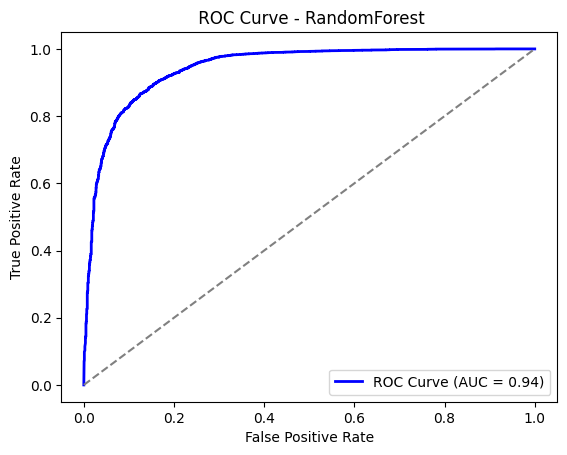


Relatório de classificação para XGBoost:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1699
           1       0.90      0.95      0.92      3718

    accuracy                           0.89      5417
   macro avg       0.88      0.86      0.87      5417
weighted avg       0.89      0.89      0.89      5417



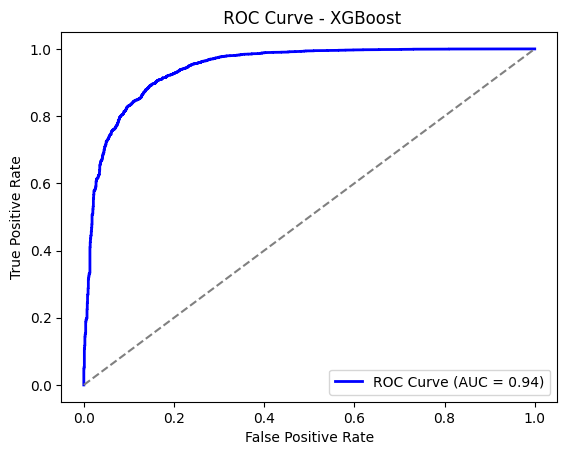


Relatório de classificação para CatBoost:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1699
           1       0.90      0.95      0.92      3718

    accuracy                           0.89      5417
   macro avg       0.89      0.86      0.87      5417
weighted avg       0.89      0.89      0.89      5417



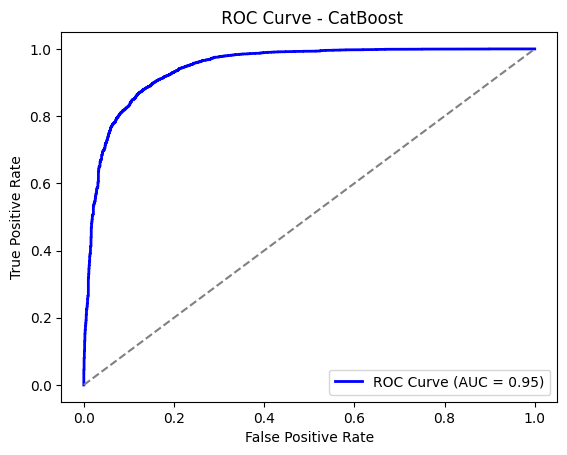


Relatório de classificação para LGBM:
              precision    recall  f1-score   support

           0       0.86      0.77      0.82      1699
           1       0.90      0.94      0.92      3718

    accuracy                           0.89      5417
   macro avg       0.88      0.86      0.87      5417
weighted avg       0.89      0.89      0.89      5417



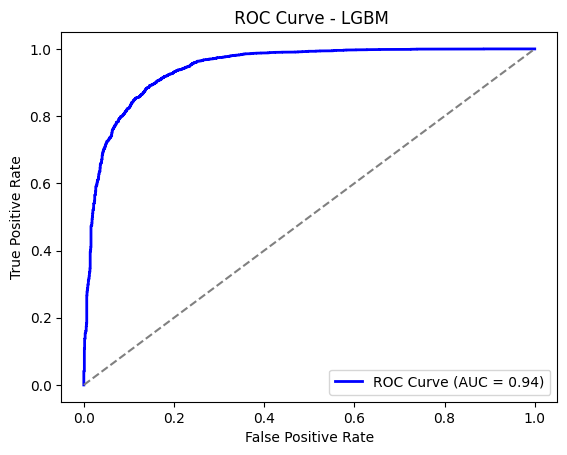

In [ ]:
# Avaliação dos modelos no conjunto de teste
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Relatório de classificação
    print(f"\nRelatório de classificação para {model_name}:")
    print(classification_report(y_test, y_pred))

    #  ROC Curve e AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot da  ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f' ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

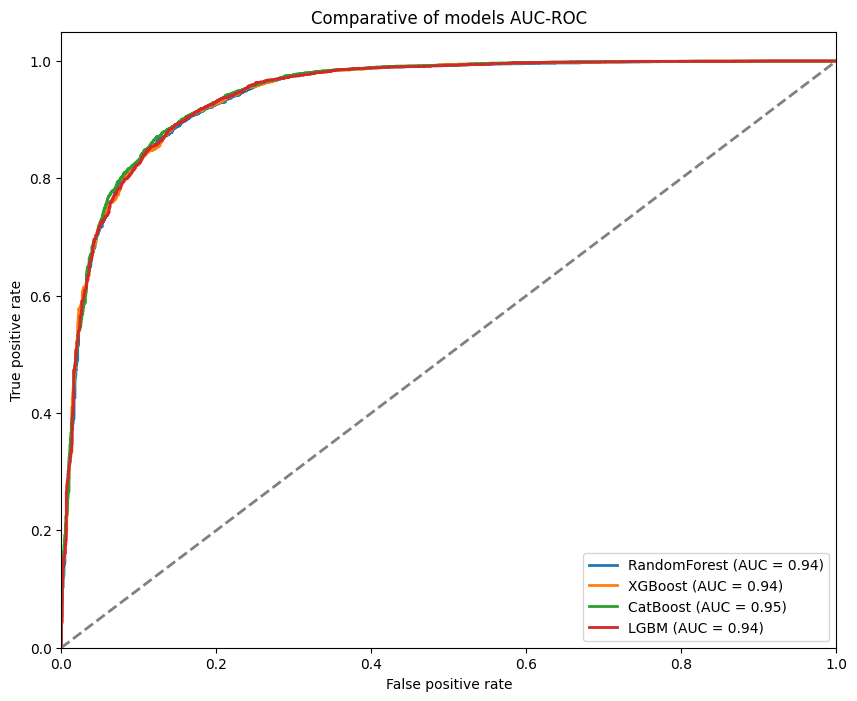

In [ ]:
# Avaliação dos modelos no conjunto de teste
plt.figure(figsize=(10, 8))

for model_name, model in best_models.items():
    # Obtenção das probabilidades de predição
    y_proba = model.predict_proba(X_test)[:, 1]

    #  ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot da  ROC Curve para cada modelo
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Linha diagonal de referência
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Comparative of models AUC-ROC')
plt.legend(loc="lower right")
#plt.grid(alpha=0.3)
#plt.savefig(f"/content/drive/MyDrive/trabalhos/ML Predição minigites /roc_auc_models_300dpi.png", dpi=300)
plt.show()

Modelo com melhor AUC no teste: CatBoost


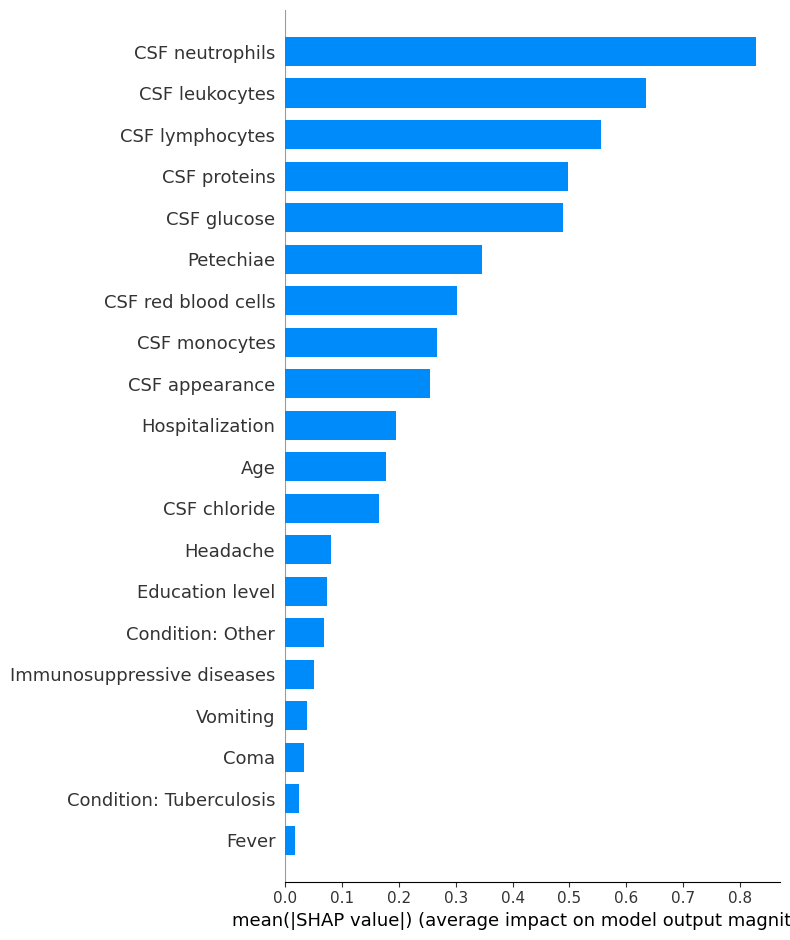

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Identificar o melhor modelo com base na métrica AUC no conjunto de teste
best_model_name = max(best_models, key=lambda name: roc_auc_score(y_test, best_models[name].predict_proba(X_test)[:, 1]))
best_model = best_models[best_model_name]
print(f"Modelo com melhor AUC no teste: {best_model_name}")

# Criar o interpretador SHAP com amostras de teste
explainer = shap.TreeExplainer(best_model) if best_model_name in ['Random Forest', 'CatBoost', 'LGBM', 'XGBoost'] else shap.KernelExplainer(best_model.predict_proba, X_test)
shap_values = explainer.shap_values(X_test)

# Substituir os nomes das colunas em X_test de acordo com o mapeamento
mapping = {
    "idade": "Age",
    "sexo": "Sex",
    "CS_RACA": "Race",
    "CS_ESCOL_N": "Education level",
    "CS_GESTANT": "Pregnancy status",
    "ID_MUNICIP": "City ID",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "NM_BAIRRO": "Neighborhood name",
    "CS_ZONA": "Residential area type",
    "ANT_AIDS": "AIDS/HIV",
    "ANT_IMUNO": "Immunosuppressive diseases",
    "ANT_TUBE": "Condition: Tuberculosis",
    "ANT_TRAUMA": "Condition: Trauma",
    "ANT_INF_HO": "Condition: Hospital-acquired infection",
    "ANT_OUTRO": "Condition: Other",
    "contato_caso": "Contact with case",
    "cefaleia": "Headache",
    "febre": "Fever",
    "vomito": "Vomiting",
    "convulsoes": "Convulsions",
    "rigidez_nuca": "Neck stiffness",
    "Kernig_brudzinski": "Kernig/Brudzinski sign",
    "abaula_fontanela": "Fontanelle bulging",
    "coma": "Coma",
    "petequias": "Petechiae",
    "LAB_ASPECT": "CSF appearance",
    "LAB_HEMA": "CSF red blood cells",
    "LAB_NEUTRO": "CSF neutrophils",
    "LAB_GLICO": "CSF glucose",
    "LAB_LEUCO": "CSF leukocytes",
    "LAB_PROT": "CSF proteins",
    "LAB_MONO": "CSF monocytes",
    "LAB_LINFO": "CSF lymphocytes",
    "LAB_CLOR": "CSF chloride",
    "internacao": "Hospitalization"
}

# Renomear as colunas de X_test
X_test_renamed = X_test.rename(columns=mapping)

# Visualização dos valores SHAP para a classe positiva
if isinstance(shap_values, list):  # Caso de múltiplas classes (e.g., árvore de decisão)
    shap_values_class = shap_values[1]  # Classe positiva
else:
    shap_values_class = shap_values

# Gráfico de Importância das Variáveis com rótulos atualizados
shap.summary_plot(shap_values_class, X_test_renamed, plot_type="bar")

# Salva o gráfico com 300 DPI
#plt.savefig("/content/drive/MyDrive/trabalhos/ML Predição minigites/shap_bar_300dpi_en.png", dpi=300, bbox_inches='tight')
plt.show()  # Mostra o gráfico apenas se necessário


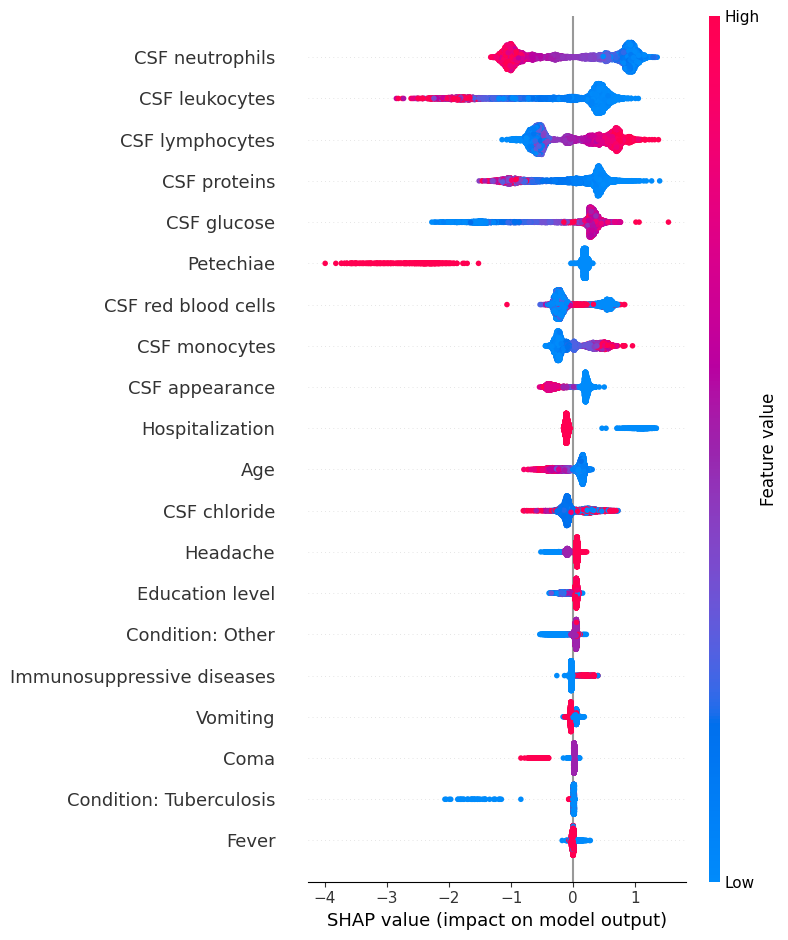

In [ ]:
# Gráfico de Beeswarm para uma visão detalhada
shap.summary_plot(shap_values_class, X_test_renamed)
plt.show()  # Mostra o gráfico apenas se necessário

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import pandas as pd

# Tabela para armazenar os resultados
summary_results = []

# Loop pelos melhores modelos para calcular as métricas
for model_name, model in best_models.items():
    # Previsões de probabilidade para a classe positiva
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calcular a  ROC Curve e AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Encontrar o threshold que maximiza a sensibilidade
    max_sensitivity_idx = np.argmax(tpr)
    best_threshold = thresholds[max_sensitivity_idx]

    # Calcular as previsões binárias usando o threshold otimizado
    y_pred_best_threshold = (y_proba >= best_threshold).astype(int)

    # Calcular métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred_best_threshold)
    recall = recall_score(y_test, y_pred_best_threshold)
    precision = precision_score(y_test, y_pred_best_threshold)
    f1 = f1_score(y_test, y_pred_best_threshold)
    mcc = matthews_corrcoef(y_test, y_pred_best_threshold)

    # Calcular matriz de confusão para especificidade
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_best_threshold).ravel()
    specificity = tn / (tn + fp)

    # Adiciona os resultados na tabela de sumarização
    summary_results.append({
        'Modelo': model_name,
        'AUC-ROC': f"{roc_auc:.2f}",
        'Accuracy': f"{accuracy:.2f}",
        'Recall': f"{recall:.2f}",
        'Specificity': f"{specificity:.2f}",
        'Precision': f"{precision:.2f}",
        'F1': f"{f1:.2f}",
        'MCC': f"{mcc:.2f}"
    })

# Converte a lista de resultados para um DataFrame para visualização
summary_df = pd.DataFrame(summary_results)
summary_df

,Modelo,AUC-ROC,Accuracy,Recall,Specificity,Precision,F1,MCC
0,RandomForest,0.94,0.71,1.00,0.09,0.71,0.83,0.25
1,XGBoost,0.94,0.74,1.00,0.17,0.73,0.84,0.35
2,CatBoost,0.95,0.72,1.00,0.10,0.71,0.83,0.27
3,LGBM,0.94,0.72,1.00,0.11,0.71,0.83,0.28


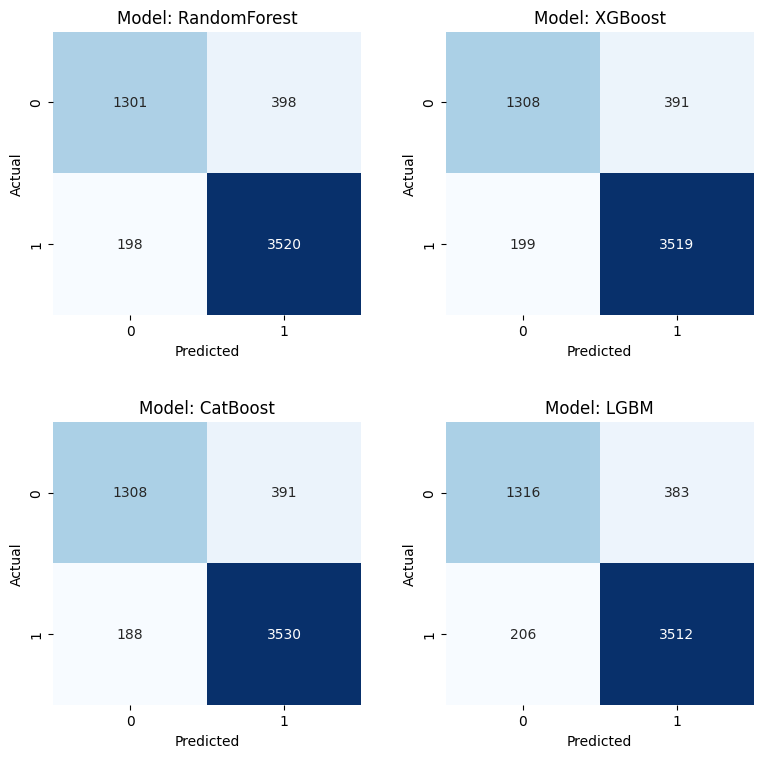

In [ ]:

#Matriz de confusao
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set the figure size to A4
plt.figure(figsize=(8.27, 11.69))

# Loop through the best models to calculate metrics and plot confusion matrices
for idx, (model_name, model) in enumerate(best_models.items(), start=1):
    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate binary predictions using a fixed threshold of 0.5
    y_pred_0_5 = (y_proba >= 0.5).astype(int)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_0_5)

    # Subplot for each confusion matrix
    plt.subplot(3, 2, idx)  # Adjust based on the number of models
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Model: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    if idx == 5:
        break  # Exit the loop after the fifth model

# Adjust spacing between subplots
plt.tight_layout(pad=3.0)

# Display the figure
plt.show()

# Modelo 2: classificação de sorogrupo (dentro das bacterianas)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
# Carregar o dataset
file_path = "/content/drive/MyDrive/ PROJETOS/ML Predição minigites /dados_bacteriana_tipo.csv"
data = pd.read_csv(file_path)

In [ ]:
# Carregar o dataset
data = pd.read_csv("df_treino_intrabac.csv")
data.head()

,NU_NOTIFIC,DT_NOTIFIC,etiologia,grupo_etiologico,idade,faixa_etaria1,faixa_etaria2,faixa_etaria3,sexo,CS_RACA,...,LAB_HEMA,LAB_NEUTRO,LAB_GLICO,LAB_LEUCO,LAB_PROT,LAB_MONO,LAB_LINFO,LAB_CLOR,internacao,evolucao
0,6716079,2018-05-04,Outra bacteria,Bacteriana,16.0,15 a 19 anos,15 a 19 anos,10 a 19 anos,Masculino,1.0,...,422.0,75.0,49.0,5960.0,682.0,NaN,25.0,117.0,Sim,Alta
1,4732085,2019-04-26,Outra bacteria,Bacteriana,2.0,0 a 4 anos,2 a 4 anos,2 a 4 anos,Feminino,9.0,...,5280.0,74.0,54.0,240.0,48.0,8.0,18.0,695.0,Sim,Alta
2,4633866,2019-04-26,Outra bacteria,Bacteriana,51.0,40 a 59 anos,40 a 59 anos,40 a 59 anos,Masculino,9.0,...,1821.0,83.0,163.0,181.0,182.0,2.0,13.0,NaN,Sim,Ignorado
3,4723752,2019-04-26,Meningococo,Bacteriana,22.0,20 a 39 anos,20 a 29 anos,20 a 39 anos,Masculino,4.0,...,NaN,12.0,75.0,1.0,22.0,25.0,61.0,NaN,Sim,Alta
4,4878257,2019-04-09,Hemofilo,Bacteriana,0.0,0 a 4 anos,< 1 ano,< 1 ano,Masculino,1.0,...,70.0,50.0,25.0,220.0,110.0,5.0,45.0,NaN,Sim,Alta


In [ ]:
pd.set_option('display.max_columns', None)
data.head()

,NU_NOTIFIC,DT_NOTIFIC,etiologia,grupo_etiologico,idade,faixa_etaria1,faixa_etaria2,faixa_etaria3,sexo,CS_RACA,CS_ESCOL_N,CS_GESTANT,ID_MUNICIP,latitude,longitude,NM_BAIRRO,CS_ZONA,ANT_AIDS,ANT_IMUNO,ANT_TUBE,ANT_TRAUMA,ANT_INF_HO,ANT_OUTRO,contato_caso,cefaleia,febre,vomito,convulsoes,rigidez_nuca,Kernig_brudzinski,abaula_fontanela,coma,petequias,LAB_ASPECT,LAB_CTLIQU,LAB_HEMA,LAB_NEUTRO,LAB_GLICO,LAB_LEUCO,LAB_PROT,LAB_MONO,LAB_LINFO,LAB_CLOR,internacao,evolucao
0,6716079,2018-05-04,Outra bacteria,Bacteriana,16.0,15 a 19 anos,15 a 19 anos,10 a 19 anos,Masculino,1.0,4,6,355030,-23.5329,-46.6395,VILA PRUDENTE,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Sem historia de contato,Sim,Nao,Nao,Nao,Sim,Nao,Nao,Nao,Nao,4.0,NaN,422.0,75.0,49.0,5960.0,682.0,NaN,25.0,117.0,Sim,Alta
1,4732085,2019-04-26,Outra bacteria,Bacteriana,2.0,0 a 4 anos,2 a 4 anos,2 a 4 anos,Feminino,9.0,10,6,355030,-23.5329,-46.6395,GUAIANASES,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Sem historia de contato,Nao,Sim,Nao,Nao,Sim,Nao,Nao,Nao,Nao,4.0,51.0,5280.0,74.0,54.0,240.0,48.0,8.0,18.0,695.0,Sim,Alta
2,4633866,2019-04-26,Outra bacteria,Bacteriana,51.0,40 a 59 anos,40 a 59 anos,40 a 59 anos,Masculino,9.0,9,6,355030,-23.6813,-46.6205,PIRAPORINHA,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Ignorado,Nao,Nao,Sim,Nao,Nao,Nao,Nao,Nao,Nao,3.0,28.0,1821.0,83.0,163.0,181.0,182.0,2.0,13.0,NaN,Sim,Ignorado
3,4723752,2019-04-26,Meningococo,Bacteriana,22.0,20 a 39 anos,20 a 29 anos,20 a 39 anos,Masculino,4.0,6,6,355030,-23.5329,-46.6395,ITAIM PAULISTA,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Sem historia de contato,Sim,Sim,Nao,Nao,Nao,Nao,Nao,Nao,Nao,1.0,NaN,NaN,12.0,75.0,1.0,22.0,25.0,61.0,NaN,Sim,Alta
4,4878257,2019-04-09,Hemofilo,Bacteriana,0.0,0 a 4 anos,< 1 ano,< 1 ano,Masculino,1.0,10,6,355030,-23.5329,-46.6395,VILA ANDRADE,1.0,2.0,2.0,2.0,2.0,2.0,2.0,Ignorado,Nao,Sim,Sim,Nao,Nao,Nao,Sim,Nao,Nao,1.0,6.0,70.0,50.0,25.0,220.0,110.0,5.0,45.0,NaN,Sim,Alta


In [ ]:
data.etiologia

,etiologia
0,Outra bacteria
1,Outra bacteria
2,Outra bacteria
3,Meningococo
4,Hemofilo
...,...
36019,Pneumococo
36020,Outra bacteria
36021,Hemofilo
36022,Outra bacteria


In [ ]:
# Definindo a variável alvo
target_column = 'etiologia'

In [ ]:
print(data['etiologia'].value_counts())

etiologia
Outra bacteria    16513
Meningococo       11683
Pneumococo         7003
Hemofilo            825
Name: count, dtype: int64


In [ ]:
data=data.loc[data.etiologia!='Outra bacteria',]

In [ ]:
print(data['etiologia'].value_counts())

etiologia
Meningococo    11683
Pneumococo      7003
Hemofilo         825
Name: count, dtype: int64


In [ ]:
data.columns

Index(['NU_NOTIFIC', 'DT_NOTIFIC', 'etiologia', 'grupo_etiologico', 'idade',
       'faixa_etaria1', 'faixa_etaria2', 'faixa_etaria3', 'sexo', 'CS_RACA',
       'CS_ESCOL_N', 'CS_GESTANT', 'ID_MUNICIP', 'latitude', 'longitude',
       'NM_BAIRRO', 'CS_ZONA', 'ANT_AIDS', 'ANT_IMUNO', 'ANT_TUBE',
       'ANT_TRAUMA', 'ANT_INF_HO', 'ANT_OUTRO', 'contato_caso', 'cefaleia',
       'febre', 'vomito', 'convulsoes', 'rigidez_nuca', 'Kernig_brudzinski',
       'abaula_fontanela', 'coma', 'petequias', 'LAB_ASPECT', 'LAB_CTLIQU',
       'LAB_HEMA', 'LAB_NEUTRO', 'LAB_GLICO', 'LAB_LEUCO', 'LAB_PROT',
       'LAB_MONO', 'LAB_LINFO', 'LAB_CLOR', 'internacao', 'evolucao'],
      dtype='object')

In [ ]:
data.drop(['NU_NOTIFIC','LAB_CTLIQU', 'DT_NOTIFIC',  'faixa_etaria1', 'faixa_etaria2', 'faixa_etaria3','evolucao', 'grupo_etiologico'],axis=1,inplace=True)

In [ ]:
# Contagem total de linhas no dataset
#total_rows = len(data)

# Calcular a porcentagem de valores faltantes para cada coluna
# missing_percentage = data.isnull().sum() / total_rows * 100

# Selecionar colunas que têm mais de 20% de valores faltantes
#columns_to_drop = missing_percentage[missing_percentage > 20].index

# Exibir as colunas que serão removidas
#print("\nColunas a serem removidas (mais de 200% de valores faltantes):")
#print(columns_to_drop)

# Remover as colunas do dataset
#data = data.drop(columns=columns_to_drop)

In [ ]:
# Remover valores faltantes
data.dropna(inplace=True)

In [ ]:
# data[['faixa_etaria1', 'faixa_etaria2', 'faixa_etaria3']]

In [ ]:
# Atualizando listas de features categóricas e numéricas baseadas nas colunas disponíveis
categorical_features_all = ['sexo', 'CS_RACA',  'ID_MUNICIP',
       'latitude', 'longitude', 'NM_BAIRRO', 'CS_ZONA', 'ANT_AIDS',
       'ANT_IMUNO', 'ANT_TUBE', 'ANT_TRAUMA', 'ANT_INF_HO', 'ANT_OUTRO',
       'contato_caso', 'cefaleia', 'febre', 'vomito', 'convulsoes',
       'rigidez_nuca', 'Kernig_brudzinski', 'abaula_fontanela', 'coma',
       'petequias', 'internacao']

numeric_features_all = ['idade', 'ID_MUNICIP', 'CS_ESCOL_N','CS_GESTANT', 'LAB_ASPECT', 'LAB_CTLIQU', 'LAB_HEMA', 'LAB_NEUTRO',
       'LAB_GLICO', 'LAB_LEUCO', 'LAB_PROT', 'LAB_MONO', 'LAB_LINFO',
       'LAB_CLOR','latitude', 'longitude']

# Identificar as colunas presentes no dataset atual
categorical_features = [col for col in categorical_features_all if col in data.columns]
numeric_features = [col for col in numeric_features_all if col in data.columns]

# Separando a variável alvo e as features
X = data.drop(columns=[target_column])
y = data[target_column]

In [ ]:
# Dividindo em treino e teste, mantendo a proporção da classe
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# # Realizar value_counts em todas as colunas e exibir os resultados
# for col in X.columns:
#     print(f"Value counts para a coluna '{col}':")
#     print(X[col].value_counts(dropna=False))  # dropna=False para incluir contagem de NaNs
#     print("\n" + "-"*50 + "\n")

In [ ]:
# Convertendo a variável alvo para valores numéricos com Label Encoding
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

# Criando um DataFrame temporário que inclui X_train e y_train_encoded para Target Encoding
temp_train = X_train.copy()
temp_train[target_column] = y_train_encoded

# Aplicar Target Encoding para features com mais de 5 categorias e Label Encoding para as demais
for col in categorical_features:
    unique_values = X_train[col].nunique()

    if unique_values > 5:
        # Calcula a média da variável alvo codificada para cada categoria na feature
        mean_encoding = temp_train.groupby(col)[target_column].transform('mean')
        X_train[col] = X_train[col].map(mean_encoding)
        X_test[col] = X_test[col].map(mean_encoding)
        # print(f"Aplicado Target Encoding na feature '{col}' com {unique_values} categorias.")
    else:
        # Aplicar Label Encoding para features com 5 ou menos categorias
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        # print(f"Aplicado Label Encoding na feature '{col}'.")

# Atualizar y_train e y_test para os valores codificados
y_train = y_train_encoded
y_test = y_test_encoded

# Verificação final dos tipos de dados
# print("\nVerificação final dos tipos de dados após encoding:")
# print(X_train.dtypes)

In [ ]:
# Normalizando as variáveis numéricas presentes no dataset
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Obtendo o número de classes e pesos para problemas de classe desbalanceada
classes, counts = np.unique(y_train, return_counts=True)
class_weights = counts / len(y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
# Definindo os modelos e hiperparâmetros para validação cruzada
models = {
    'RandomForest': (RandomForestClassifier(random_state=42, class_weight='balanced'), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss',
                              objective='multi:softmax', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])), {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200]
    }),
    'CatBoost': (CatBoostClassifier(random_state=42, silent=True,
                                    class_weights=class_weights), {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.3],
        'iterations': [100, 200]
    }),
    'LGBM': (LGBMClassifier(random_state=42, class_weight='balanced'), {
        'num_leaves': [31, 50],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200]
    })
}

In [ ]:
# Validação cruzada para cada modelo
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}

for model_name, (model, params) in models.items():
    print(f"\nRodando GridSearchCV para {model_name}...")
    grid_search = GridSearchCV(model, param_grid=params, cv=cv, scoring='roc_auc_ovr', n_jobs=-1, verbose=1, error_score='raise')
    try:
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")
    except ValueError as e:
        print(f"Erro ao ajustar {model_name}: {e}")


Rodando GridSearchCV para RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores hiperparâmetros para RandomForest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Rodando GridSearchCV para XGBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:55:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

Rodando GridSearchCV para CatBoost...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores hiperparâmetros para CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}

Rodando GridSearchCV para LGBM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1488
[LightGBM] [Info] Number of data points in the train set: 3516, number of used features: 30
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Melhores hiperparâmetros para LGBM: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31

In [ ]:
# Itera sobre cada modelo para salvar o melhor estimador
for model_name, grid_search in best_models.items():
    # Verifica se é um objeto de GridSearchCV e possui o atributo best_estimator_
    if hasattr(grid_search, 'best_estimator_'):
        best_model = grid_search.best_estimator_
    else:
        best_model = grid_search  # Caso contrário, assume que é o modelo final

    dump(best_model, f'/content/drive/MyDrive/ PROJETOS/ML Predição minigites /{model_name}_best_model.joblib')
    print(f"Modelo {model_name} salvo como {model_name}_best_model.joblib")

Modelo RandomForest salvo como RandomForest_best_model.joblib
Modelo XGBoost salvo como XGBoost_best_model.joblib
Modelo CatBoost salvo como CatBoost_best_model.joblib
Modelo LGBM salvo como LGBM_best_model.joblib



Relatório de classificação para RandomForest:
               precision    recall  f1-score   support

Meningococcal       0.16      0.25      0.19        36
 Pneumococcal       0.84      0.70      0.77       494
  Haemophilus       0.65      0.77      0.71       349

     accuracy                           0.71       879
    macro avg       0.55      0.57      0.56       879
 weighted avg       0.74      0.71      0.72       879



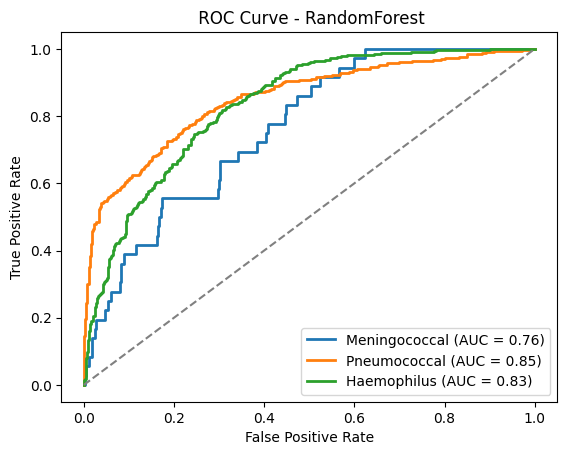


Relatório de classificação para XGBoost:
               precision    recall  f1-score   support

Meningococcal       0.00      0.00      0.00        36
 Pneumococcal       0.79      0.82      0.81       494
  Haemophilus       0.71      0.74      0.72       349

     accuracy                           0.76       879
    macro avg       0.50      0.52      0.51       879
 weighted avg       0.73      0.76      0.74       879



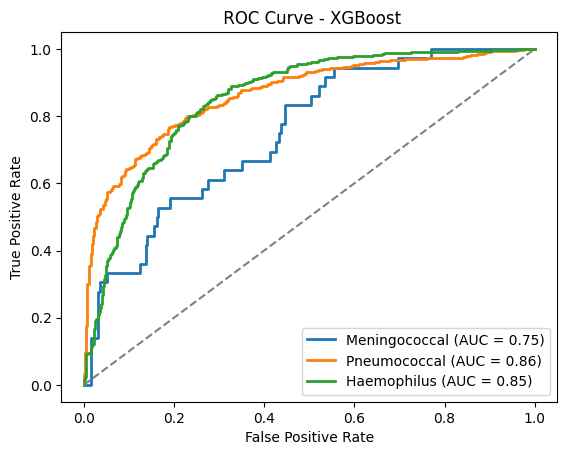


Relatório de classificação para CatBoost:
               precision    recall  f1-score   support

Meningococcal       0.00      0.00      0.00        36
 Pneumococcal       0.77      0.88      0.82       494
  Haemophilus       0.75      0.68      0.71       349

     accuracy                           0.76       879
    macro avg       0.51      0.52      0.51       879
 weighted avg       0.73      0.76      0.74       879



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


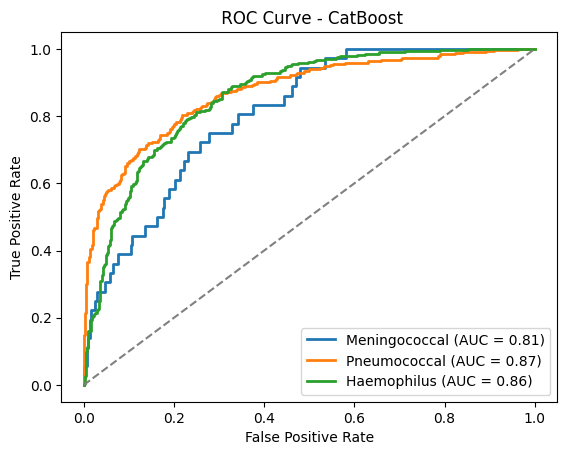


Relatório de classificação para LGBM:
               precision    recall  f1-score   support

Meningococcal       0.12      0.33      0.17        36
 Pneumococcal       0.87      0.69      0.77       494
  Haemophilus       0.66      0.73      0.69       349

     accuracy                           0.69       879
    macro avg       0.55      0.58      0.55       879
 weighted avg       0.76      0.69      0.72       879



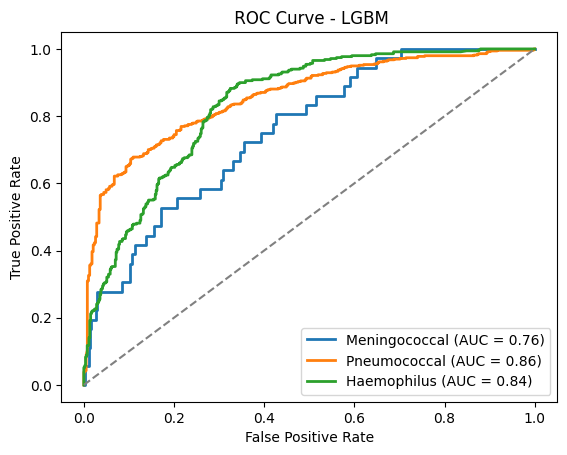

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Definindo as classes e binarizando y_test
class_names = ['Meningococcal', 'Pneumococcal', 'Haemophilus']
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Avaliação dos modelos no conjunto de teste
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Relatório de classificação
    print(f"\nRelatório de classificação para {model_name}:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    #  ROC Curve e AUC para cada classe
    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot da  ROC Curve para cada classe
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f' ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()


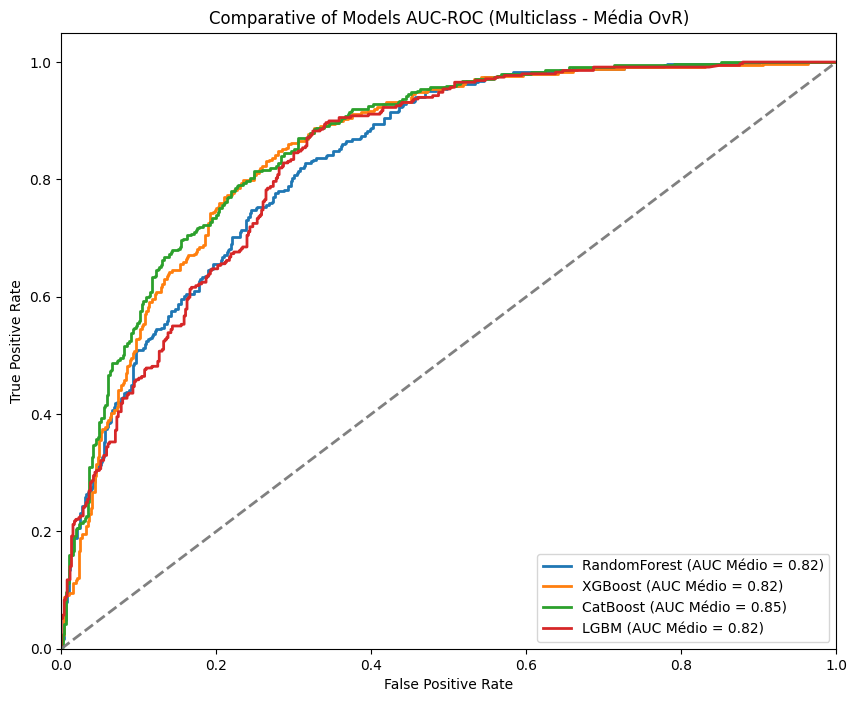

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Definindo as classes
class_names = ['Meningococcal', 'Pneumococcal', 'Haemophilus']
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Avaliação dos modelos no conjunto de teste
plt.figure(figsize=(10, 8))

for model_name, model in best_models.items():
    # Obtenção das probabilidades de predição
    y_proba = model.predict_proba(X_test)

    # Calculando a  ROC Curve e AUC para cada classe e somando para obter a média do AUC
    mean_auc = 0
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        mean_auc += roc_auc / n_classes  # Média do AUC para o modelo

    # Plot da  ROC Curve média para cada modelo
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC Médio = {mean_auc:.2f})')

# Linha diagonal de referência
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative of Models AUC-ROC (Multiclass - Média OvR)')
plt.legend(loc="lower right")
plt.show()


Modelo com melhor AUC no teste: CatBoost


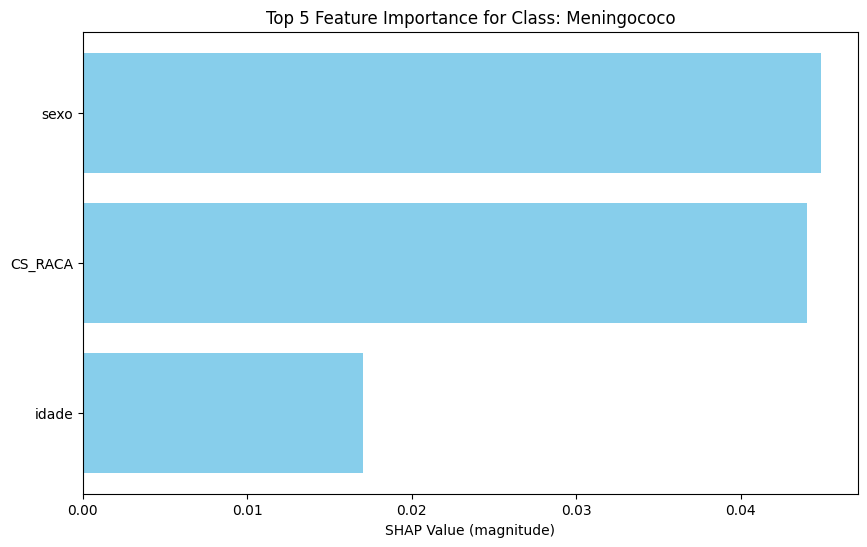

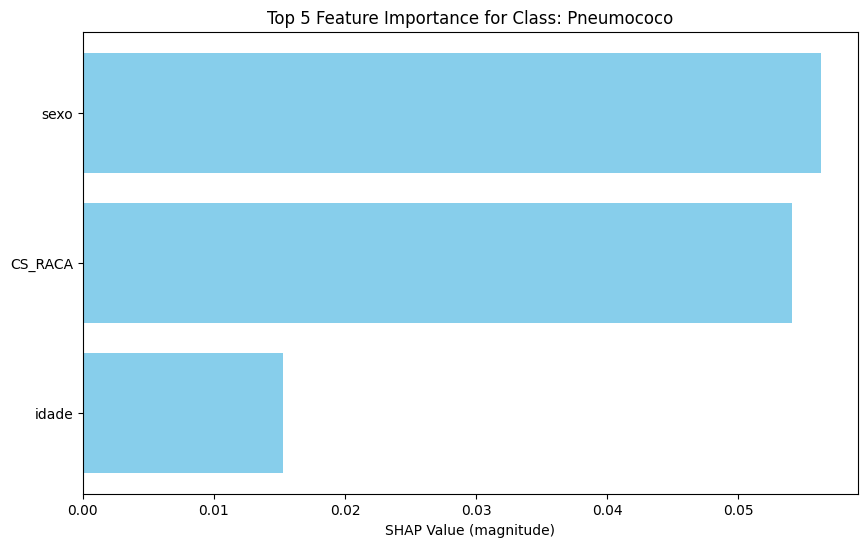

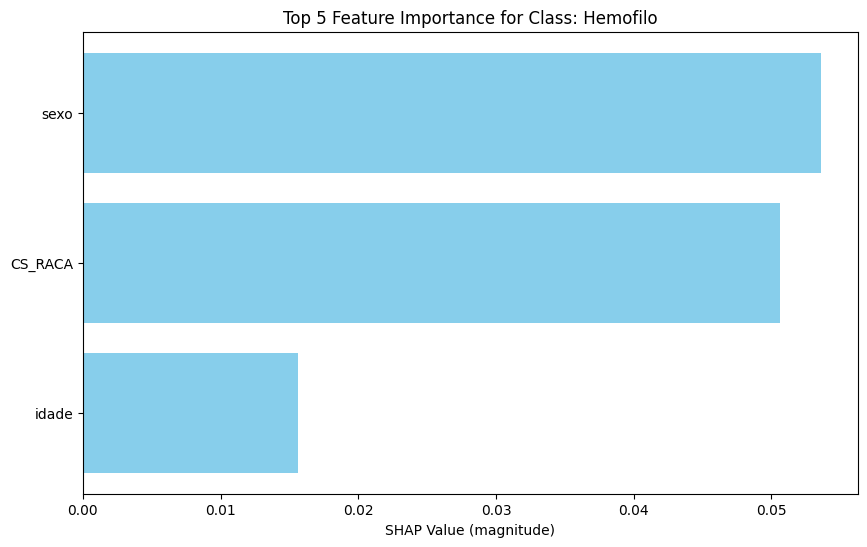

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Identificar o melhor modelo com base na métrica AUC média no conjunto de teste (multiclasse)
best_model_name = max(best_models, key=lambda name: roc_auc_score(y_test, best_models[name].predict_proba(X_test), multi_class="ovr"))
best_model = best_models[best_model_name]
print(f"Modelo com melhor AUC no teste: {best_model_name}")

# Criar o interpretador SHAP (assumindo que é um modelo de boosting)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Nomes das classes e variáveis
class_names = ['Meningococo', 'Pneumococo', 'Hemofilo']
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {i}' for i in range(X_test.shape[1])]

# Plotar a importância média das variáveis para cada classe em formato de barras (top 5)
for i, class_name in enumerate(class_names):
    # Calcular a importância média das variáveis para a classe específica
    shap_mean = np.abs(shap_values[i]).mean(axis=0)

    # Ordenar as variáveis por importância e selecionar as 5 principais
    sorted_indices = np.argsort(shap_mean)[::-1][:5]
    sorted_shap_mean = shap_mean[sorted_indices]
    sorted_feature_names = [feature_names[idx] for idx in sorted_indices]

    # Plotar em formato de barras
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_shap_mean, color='skyblue')
    plt.xlabel("SHAP Value (magnitude)")
    plt.title(f"Top 5 Feature Importance for Class: {class_name}")
    plt.gca().invert_yaxis()  # Inverter o eixo y para exibir o mais importante no topo
    plt.show()


Modelo com melhor AUC no teste: CatBoost


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


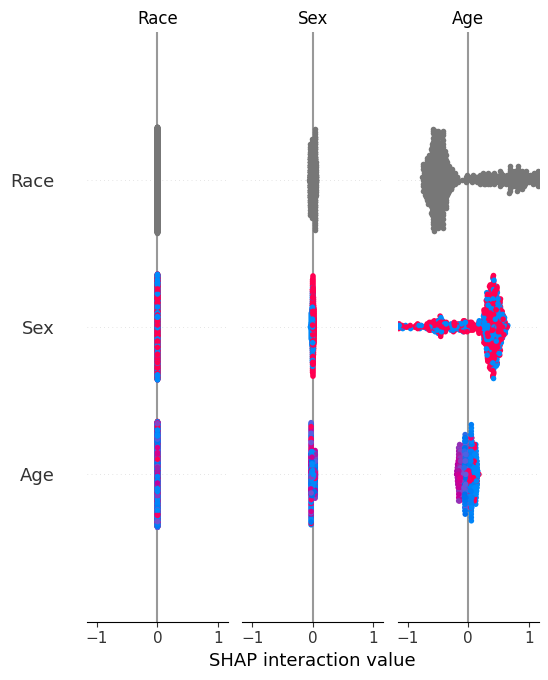

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Identificar o melhor modelo com base na métrica AUC no conjunto de teste
best_model_name = max(best_models, key=lambda name: roc_auc_score(
    y_test,
    best_models[name].predict_proba(X_test),
    multi_class='ovr',
    average='macro'
))
best_model = best_models[best_model_name]
print(f"Modelo com melhor AUC no teste: {best_model_name}")

# Criar o interpretador SHAP com amostras de teste
explainer = shap.TreeExplainer(best_model) if best_model_name in ['Random Forest', 'CatBoost', 'LGBM', 'XGBoost'] else shap.KernelExplainer(best_model.predict_proba, X_test)
shap_values = explainer.shap_values(X_test)

# Substituir os nomes das colunas em X_test de acordo com o mapeamento
mapping = {
    "idade": "Age",
    "sexo": "Sex",
    "CS_RACA": "Race",
    "CS_ESCOL_N": "Education level",
    "CS_GESTANT": "Pregnancy status",
    "ID_MUNICIP": "City ID",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "NM_BAIRRO": "Neighborhood name",
    "CS_ZONA": "Residential area type",
    "ANT_AIDS": "AIDS/HIV",
    "ANT_IMUNO": "Immunosuppressive diseases",
    "ANT_TUBE": "Condition: Tuberculosis",
    "ANT_TRAUMA": "Condition: Trauma",
    "ANT_INF_HO": "Condition: Hospital-acquired infection",
    "ANT_OUTRO": "Condition: Other",
    "contato_caso": "Contact with case",
    "cefaleia": "Headache",
    "febre": "Fever",
    "vomito": "Vomiting",
    "convulsoes": "Convulsions",
    "rigidez_nuca": "Neck stiffness",
    "Kernig_brudzinski": "Kernig/Brudzinski sign",
    "abaula_fontanela": "Fontanelle bulging",
    "coma": "Coma",
    "petequias": "Petechiae",
    "LAB_ASPECT": "CSF appearance",
    "LAB_CTLIQU": "CSF culture result",
    "LAB_HEMA": "CSF red blood cells",
    "LAB_NEUTRO": "CSF neutrophils",
    "LAB_GLICO": "CSF glucose",
    "LAB_LEUCO": "CSF leukocytes",
    "LAB_PROT": "CSF proteins",
    "LAB_MONO": "CSF monocytes",
    "LAB_LINFO": "CSF lymphocytes",
    "LAB_CLOR": "CSF chloride",
    "internacao": "Hospitalization"
}

# Renomear as colunas de X_test
X_test_renamed = X_test.rename(columns=mapping)

# Visualização dos valores SHAP para a classe positiva
if isinstance(shap_values, list):  # Caso de múltiplas classes
    shap_values_class = shap_values[1]  # Classe positiva
else:
    shap_values_class = shap_values

# Gráfico de Importância das Variáveis com rótulos atualizados
shap.summary_plot(shap_values_class, X_test_renamed, plot_type="bar")

# Salva o gráfico com 300 DPI, se necessário
#plt.savefig("/content/drive/MyDrive/trabalhos/ML Predição minigites/shap_bar_300dpi_en.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize

# Binarize y_test for multiclass roc_curve calculation
class_names = np.unique(y_test)  # Replace with actual class names if needed
y_test_binarized = label_binarize(y_test, classes=class_names)
n_classes = y_test_binarized.shape[1]

# Table to store the results
summary_results = []

# Loop through the best models to calculate the metrics
for model_name, model in best_models.items():
    # Get the probability predictions for each class
    y_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)  # Get predictions for accuracy and MCC calculation

    # Initialize variables to store metrics for averaging
    roc_auc_sum = 0
    recall_sum = 0
    precision_sum = 0
    f1_sum = 0
    specificity_sum = 0

    # Calculate ROC and AUC for each class
    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_sum += roc_auc

        # Find the threshold that maximizes sensitivity (recall)
        max_sensitivity_idx = np.argmax(tpr)
        best_threshold = thresholds[max_sensitivity_idx]

        # Convert probabilities to binary predictions using the best threshold
        y_pred_best_threshold = (y_proba[:, i] >= best_threshold).astype(int)
        y_test_binary = y_test_binarized[:, i]

        # Calculate metrics for this class
        recall = recall_score(y_test_binary, y_pred_best_threshold)
        precision = precision_score(y_test_binary, y_pred_best_threshold)
        f1 = f1_score(y_test_binary, y_pred_best_threshold)

        recall_sum += recall
        precision_sum += precision
        f1_sum += f1

        # Calculate specificity for this class
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_best_threshold).ravel()
        specificity = tn / (tn + fp)
        specificity_sum += specificity

    # Average metrics across classes
    avg_roc_auc = roc_auc_sum / n_classes
    avg_recall = recall_sum / n_classes
    avg_precision = precision_sum / n_classes
    avg_f1 = f1_sum / n_classes
    avg_specificity = specificity_sum / n_classes
    accuracy = accuracy_score(y_test, y_pred)  # Overall accuracy
    mcc = matthews_corrcoef(y_test, y_pred)

    # Append results to summary table
    summary_results.append({
        'Modelo': model_name,
        'AUC-ROC': f"{avg_roc_auc:.2f}",
        'Accuracy': f"{accuracy:.2f}",
        'Recall': f"{avg_recall:.2f}",
        'Specificity': f"{avg_specificity:.2f}",
        'Precision': f"{avg_precision:.2f}",
        'F1': f"{avg_f1:.2f}",
        'MCC': f"{mcc:.2f}"
    })

# Convert results list to DataFrame for display
summary_df = pd.DataFrame(summary_results)
summary_df

,Modelo,AUC-ROC,Accuracy,Recall,Specificity,Precision,F1,MCC
0,RandomForest,0.82,0.71,1.00,0.16,0.35,0.48,0.48
1,XGBoost,0.82,0.76,1.00,0.10,0.34,0.47,0.52
2,CatBoost,0.85,0.76,1.00,0.20,0.36,0.49,0.53
3,LGBM,0.82,0.69,1.00,0.14,0.35,0.48,0.47


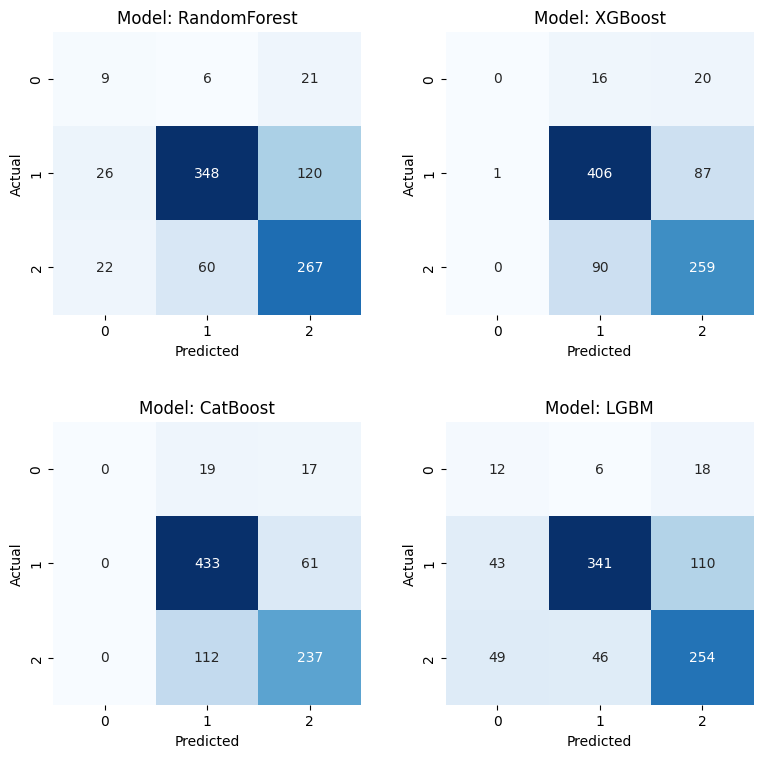

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set the figure size to A4
plt.figure(figsize=(8.27, 11.69))

# Loop through the best models to calculate metrics and plot confusion matrices
for idx, (model_name, model) in enumerate(best_models.items(), start=1):
    # Predict classes directly for multiclass classification
    y_pred = model.predict(X_test)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Subplot for each confusion matrix
    plt.subplot(3, 2, idx)  # Adjust based on the number of models
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Model: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Limit to a certain number of subplots if needed
    if idx == 5:
        break  # Exit the loop after the fifth model

# Adjust spacing between subplots
plt.tight_layout(pad=3.0)

# Display the figure
plt.show()